In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [3]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='KerasLSTMRegression'

predict_n = 10

In [4]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,NextPriceChange,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.013555,0.013679,0.619962,0.394439,0.596761,0.496869,higher,0.012863,0.383222,lower
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.013587,0.013637,0.619512,0.394997,0.595125,0.477865,lower,0.013540,0.426279,higher
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.013619,0.013618,0.619054,0.395653,0.594787,0.474037,higher,0.013508,0.419933,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.013656,0.013600,0.618669,0.396346,0.594843,0.474674,lower,0.013540,0.421875,higher
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.013658,0.013496,0.617898,0.397285,0.592643,0.449242,lower,0.013666,0.453439,higher


In [5]:
y_column = 'NextPrice'
seq_len = 5
n_splits=5
val_size = 0.2

features = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 
            'EMA(14)', 'SMA(10)', 'SMA(20) - SMA(10)','PercentageDiff', 'LowLen', 'RSI_diff', 'BodyLen', 'Volume_diff']
datasets_splits = data_wrapper.get_datasets(n_splits=n_splits, val_size=val_size, sequences=True, seq_len=5, y_column=y_column, features_list=features)

datasets_splits.shape

(5, 6)

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [6]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_regression_trainer import KerasRegressionTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf


config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=features,
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 50,
    n_splits = n_splits,
    val_size = val_size,
)

group_name = f"[{quotation}] {seq_len}-sequences : {len(features)} features  -> predict:{predict_n}, {n_splits} splits {val_size} val"


for split_id, split in tqdm(enumerate(datasets_splits)):
    #run = wandb.init(project='StockRegressionKerasLSTM', config=config_dict, group=group_name, name=f"Split {split_id+1}")
    
    (X_train, X_val, X_test, y_train, y_val, y_test) = split
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
    val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(config_dict['batch_size'])
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

    model = LSTMModel(config_dict, seq_len, len(features), output_dim=1,
                      learning_rate=config_dict['learning_rate'], loss='mse', metrics=['mae'])
    trainer = KerasRegressionTrainer(model, project_label=project_label)
    trainer.train(train_set, val_set)
    

0it [00:00, ?it/s]

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegression/runs/1if57odu
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegression/runs/373uom0i
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegression/runs/nvcgzmx5
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegression/runs/2dompei5
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegression/runs/1tjcietr


### Train a model with the full training set (train + validation) 

In [7]:
config_dict['n_epochs'] = 150

full_train_set = train_set.concatenate(val_set)
final_model = LSTMModel(config_dict, seq_len, len(features), output_dim=1,
                        learning_rate=config_dict['learning_rate'], loss='mse')
trainer = KerasRegressionTrainer(model, project_label=f"{project_label} full training-set")
trainer.train(full_train_set, val_set=test_set)

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegression%20full%20training-set/runs/32430tw0


{'prices_plot': <wandb.sdk.data_types.Image at 0x2649c0fbb88>}

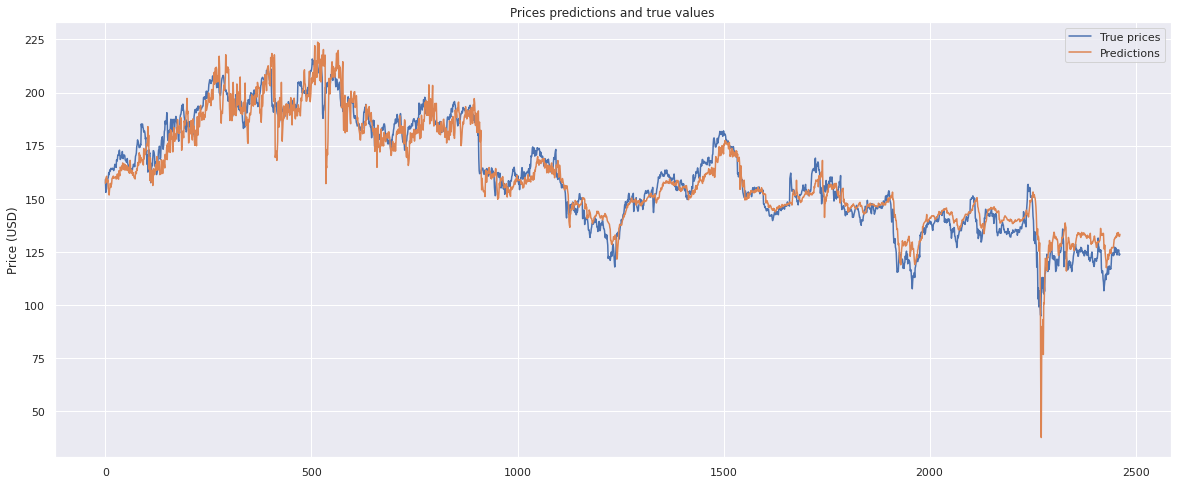

In [8]:
predictions, labels = trainer.predict(test_set)

scaled_preds = data_wrapper.get_unscaled_values(predictions, 'Close')
scaled_labels = data_wrapper.get_unscaled_values(labels, 'Close')

ax = plot_predictions(scaled_labels, scaled_preds)

### Use of lime to explain decisions

In [9]:
import lime
from lime import lime_tabular

# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
training_samples = np.concatenate([x for x, y in test_set], axis=0)
training_labels = np.concatenate([y for x, y in test_set], axis=0)


for batch in train_set.take(1):
    inputs, targets = batch

explainer = lime_tabular.RecurrentTabularExplainer(inputs, training_labels=targets,
                                                   discretize_continuous = True,
                                                   feature_names=features, class_names=y_column, 
                                                   verbose=True, mode='regression')

In [10]:
test_samples = np.concatenate([x for x, y in test_set], axis=0)

print(test_samples.shape)

(2463, 5, 12)


In [11]:
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Submodular%20Pick%20examples.ipynb

import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, test_samples, model.predict, 
                                        sample_size=15, num_features=10, num_exps_desired=5)

Intercept 0.02438342315000274
Prediction_local [0.05953817]
Right: 0.6377178
Intercept 0.02230506172692594
Prediction_local [0.06411104]
Right: 0.7648976
Intercept 0.029587315495002146
Prediction_local [0.04184671]
Right: 0.6668119
Intercept 0.030528286319960178
Prediction_local [0.04092699]
Right: 0.711553
Intercept 0.025387831290618272
Prediction_local [0.05644505]
Right: 0.70798284
Intercept 0.028556246020354958
Prediction_local [0.04521206]
Right: 0.7051063
Intercept 0.023012207113324232
Prediction_local [0.06290183]
Right: 0.65211093
Intercept 0.023880005945136625
Prediction_local [0.06033653]
Right: 0.6924106
Intercept 0.024082223539930073
Prediction_local [0.05997996]
Right: 0.64704394
Intercept 0.030002666139801216
Prediction_local [0.04221224]
Right: 0.677125
Intercept 0.025257544019132605
Prediction_local [0.05654438]
Right: 0.6399506
Intercept 0.02828767752470468
Prediction_local [0.0466196]
Right: 0.6622321
Intercept 0.025865435805635054
Prediction_local [0.05534152]
Right:

[<Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>]

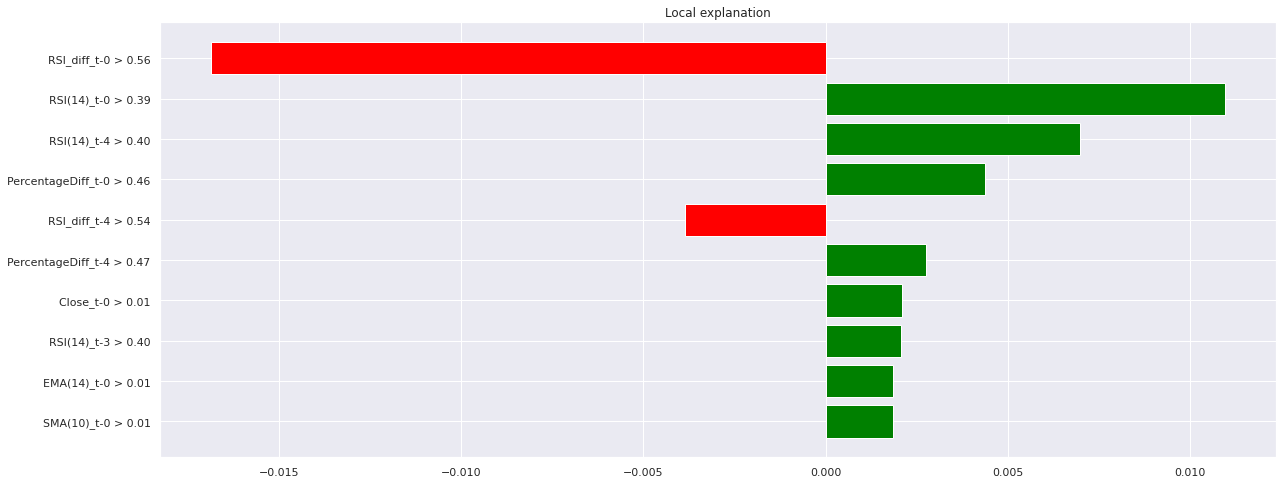

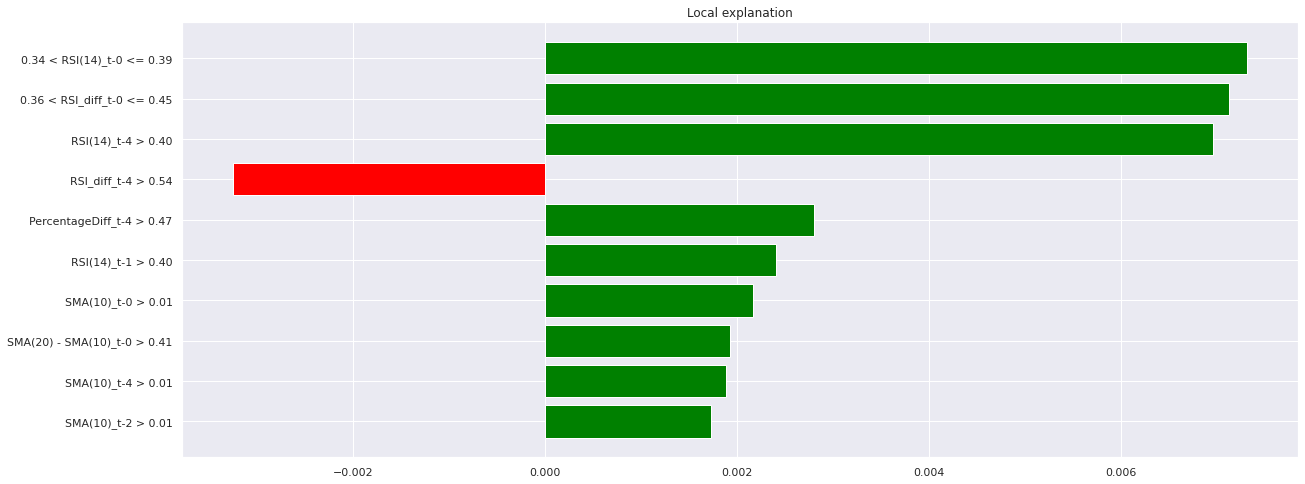

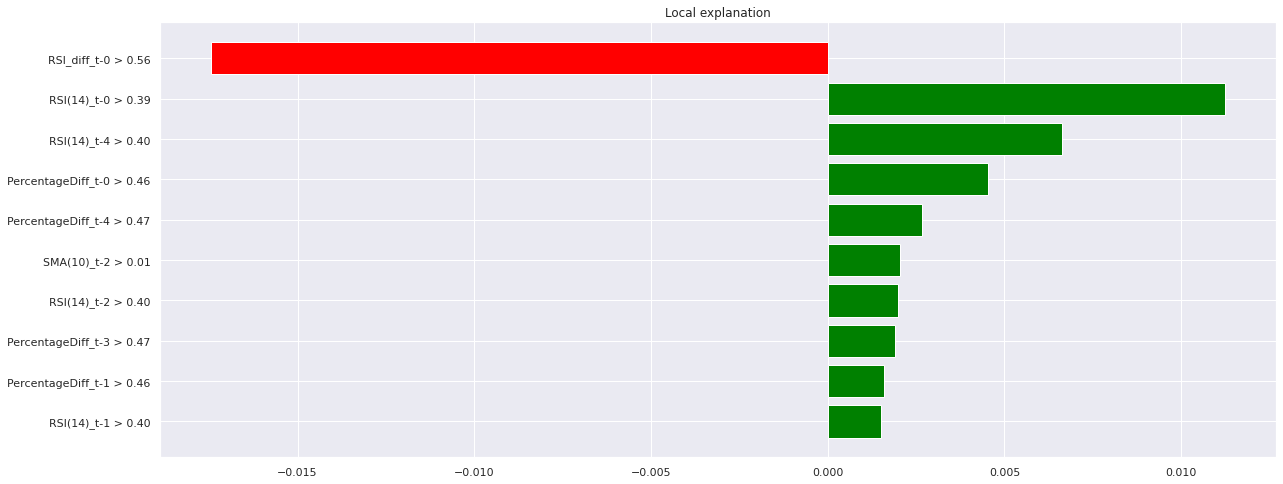

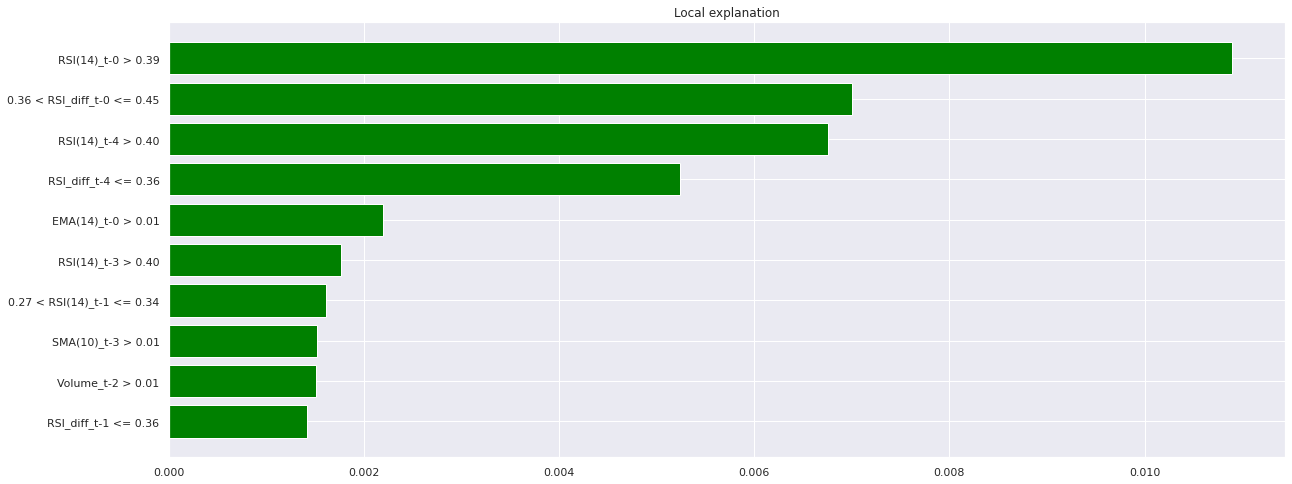

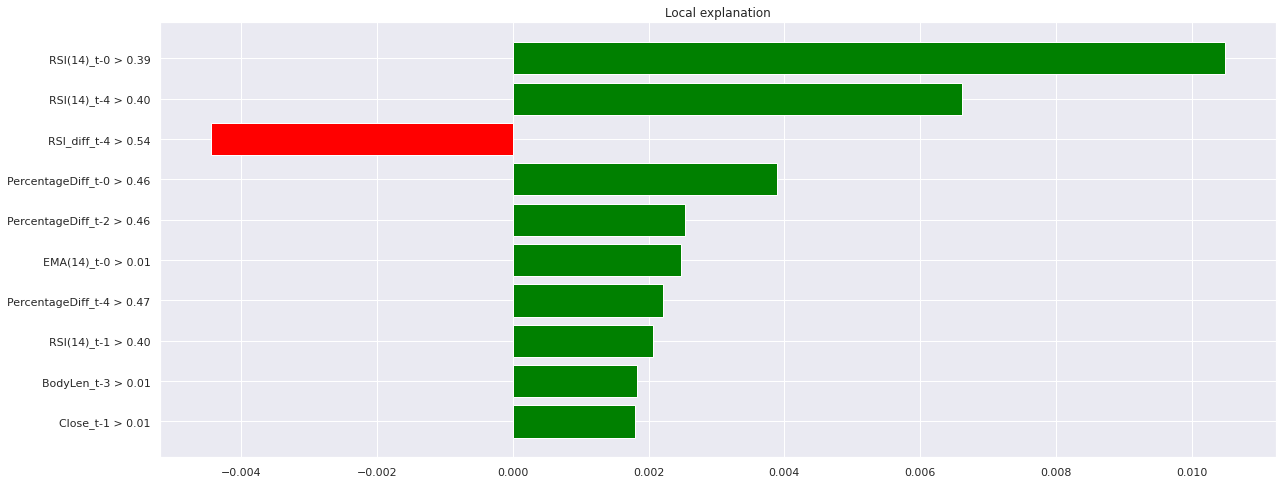

In [12]:
explanations = list(sp_obj.sp_explanations)

#print(len(explanations))

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

In [61]:
import re
exp = sp_obj.explanations[0]
exp.show_in_notebook(show_table=True)
for item in exp.as_list():
    print(item)
    feature_name, thresh = re.split("[<>]", item[0])
    weight = item[1]
    
    if '>' in item[0]:
        thresh_type ='higher'
    else:
        thresh_type='lower'
        
    print(f"{feature_name} {thresh_type} than {thresh}")

('RSI(14)_t-0 > 0.39', 0.01104768077538119)
RSI(14)_t-0  higher than  0.39
('0.36 < RSI_diff_t-0 <= 0.45', 0.006649948784921613)


ValueError: too many values to unpack (expected 2)

### Shap

In [13]:
import torch

OSError: [WinError 127] La procédure spécifiée est introuvable. Error loading "c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\lib\cufftw64_10.dll" or one of its dependencies.

In [ ]:
#import torch.nn as nn
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
# https://www.kaggle.com/phamvanvung/shap-for-lstm

# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, X_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test)
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)